In [1]:
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoLars

from sklearn.model_selection import RandomizedSearchCV

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [12]:
# Query modeling_data2 table from PostgreSQL database

try:
    conn = psycopg2.connect(user="cohort17",
                            password="Cohort17Movies",
                            host="moviesdb.ce8d6g1pa5lm.us-east-1.rds.amazonaws.com",
                            port="5432",database="moviesdb")

    dbquery = "select * from modeling_data2"
    
    movies = pd.read_sql_query(dbquery, conn)

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

finally:
    if(conn):
        conn.close()

In [13]:
model = load('gbm_randomsearch.joblib')
regressor = model.steps[-1][1]

In [14]:
X = movies.drop(['primarytitle','domesticgross'], axis=1)
y = movies['domesticgross']

features = X.columns
predictions = model.predict(X)

movies['predicted_gross'] = predictions
movies['prediction_error'] = movies['domesticgross'] - movies['predicted_gross']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
test_set = X_test
test_set['domesticgross'] = y_test
test_set['predicted_gross'] = model.predict(X_test)
test_set['prediction_error'] = test_set['domesticgross'] - test_set['predicted_gross']

c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\sklearn\compose\_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
c:\users\peper\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

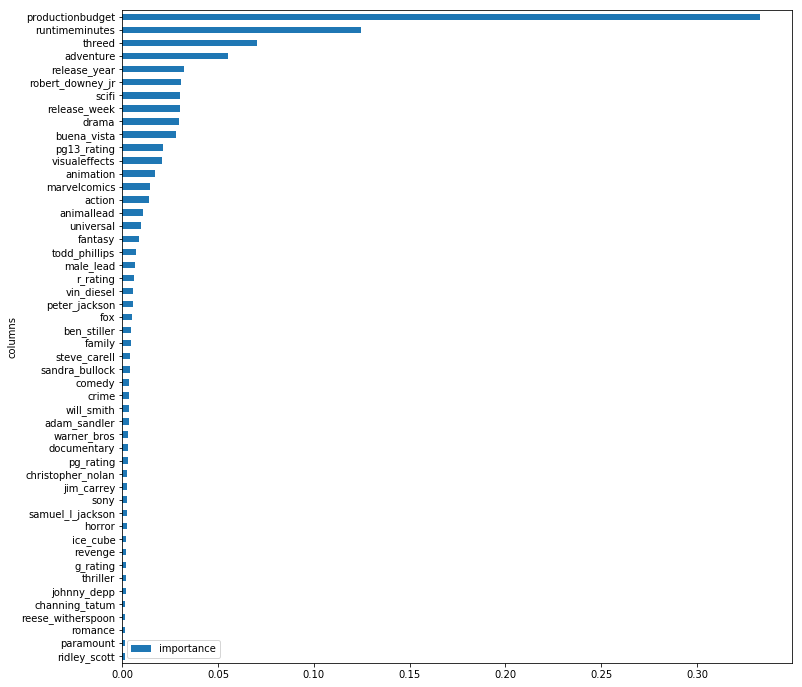

In [23]:
importance = pd.DataFrame({'columns':features,'importance': regressor.feature_importances_})
importance.sort_values('importance', ascending=True, inplace=True)
importance.tail(50).plot('columns','importance','barh',figsize=(12,12))

In [25]:
importance.head(60)['columns'].to_list()

['talkinganimals',
 'martin_scorsese',
 'm_night_shyamalan',
 'colin_farrell',
 'bruce_willis',
 'brad_pitt',
 'shawn_levy',
 'jackie_chan',
 'mark_wahlberg',
 'hugh_jackman',
 'gerard_butler',
 'keanu_reeves',
 'nicolas_cage',
 'dwayne_johnson',
 'steven_spielberg',
 'leonardo_dicaprio',
 'clint_eastwood',
 'jason_statham',
 'denzel_washington',
 'religious',
 'jake_gyllenhaal',
 'owen_wilson',
 'guy_ritchie',
 'matthew_mcconaughey',
 'ron_howard',
 'david_gordon_green',
 'russell_crowe',
 'jack_black',
 'tom_cruise',
 'matt_damon',
 'africanamerican',
 'michael_bay',
 'cate_blanchett',
 'tim_burton',
 'ben_affleck',
 'john_goodman',
 'christian_bale',
 'george_clooney',
 'dysfunctionalfamily',
 'mystery',
 'tom_hanks',
 'will_ferrell',
 'stephen_soderbergh',
 'robert_de_niro',
 'biography',
 'ridley_scott',
 'paramount',
 'romance',
 'reese_witherspoon',
 'channing_tatum',
 'johnny_depp',
 'thriller',
 'g_rating',
 'revenge',
 'ice_cube',
 'horror',
 'samuel_l_jackson',
 'sony',
 'ji

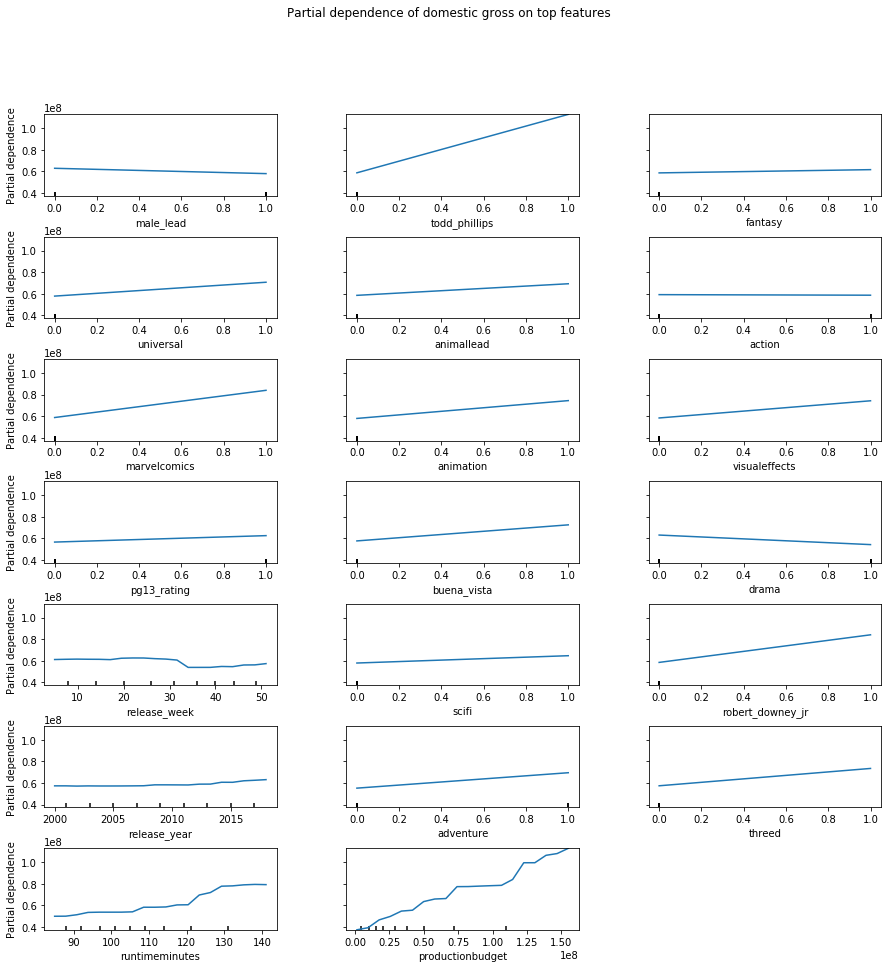

In [7]:
feature_list = importance.tail(20)['columns'].to_list()
plot_partial_dependence(model, X, feature_list, n_jobs=-1, grid_resolution=20)
fig = plt.gcf()
fig.set_size_inches(15,15)
fig.suptitle('Partial dependence of domestic gross on top features')
fig.subplots_adjust(wspace=0.3, hspace=0.5)

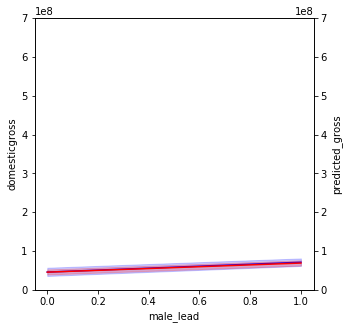

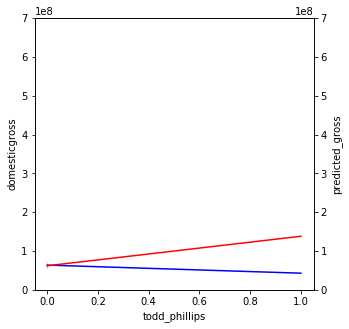

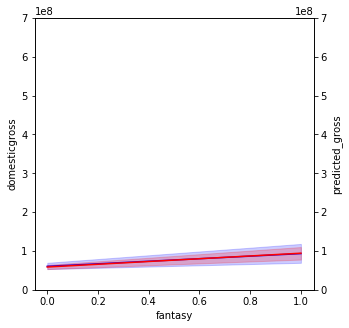

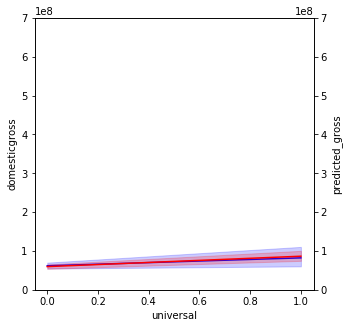

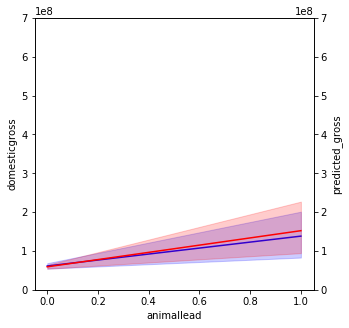

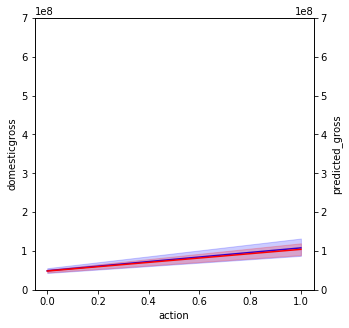

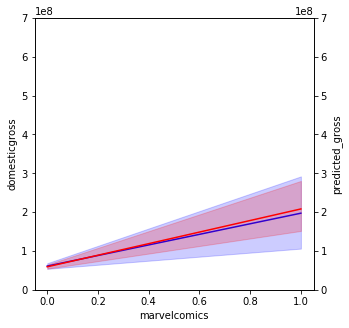

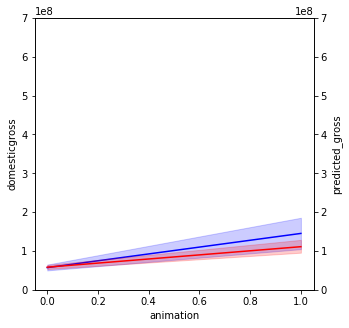

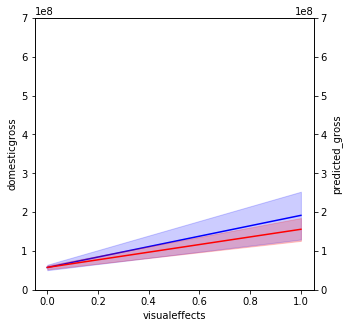

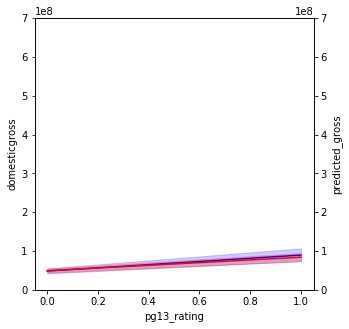

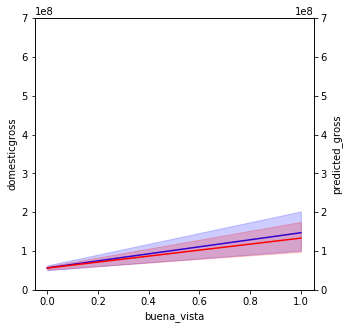

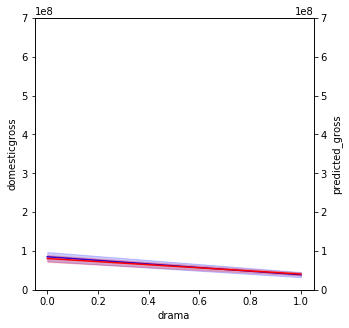

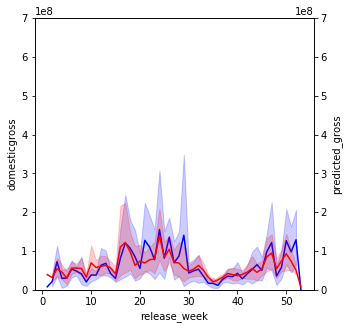

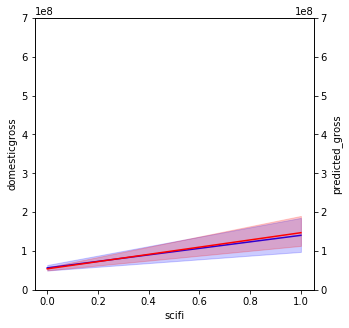

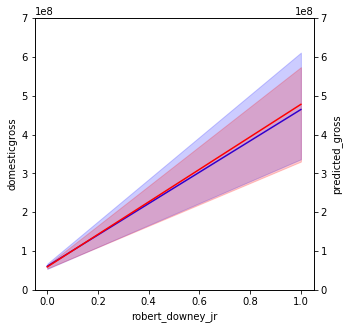

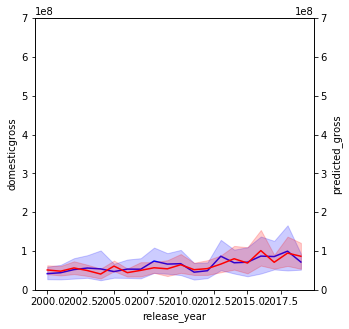

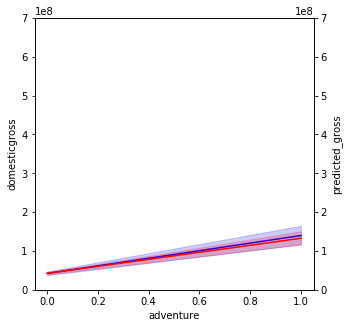

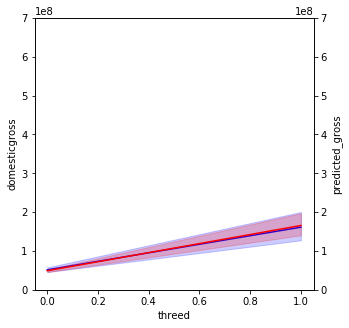

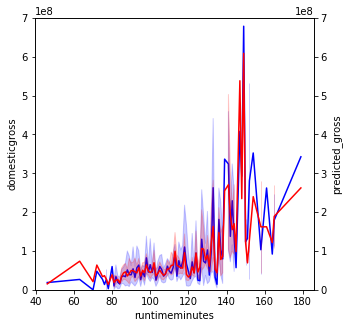

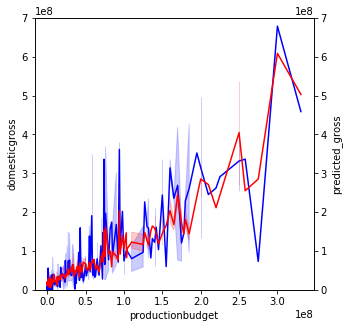

In [10]:
def make_plot(x_column, y_height):
    plt.figure(figsize=(5, 5))
    plt.ylim(0, y_height)
    sns.lineplot(data=test_set, y="domesticgross", x=x_column, color="b")
    ax2 = plt.twinx()
    ax2.set_ylim(0, y_height)
    sns.lineplot(data=test_set, y="predicted_gross", x=x_column, color="r")

for feature in features:
    make_plot(feature, 700000000)